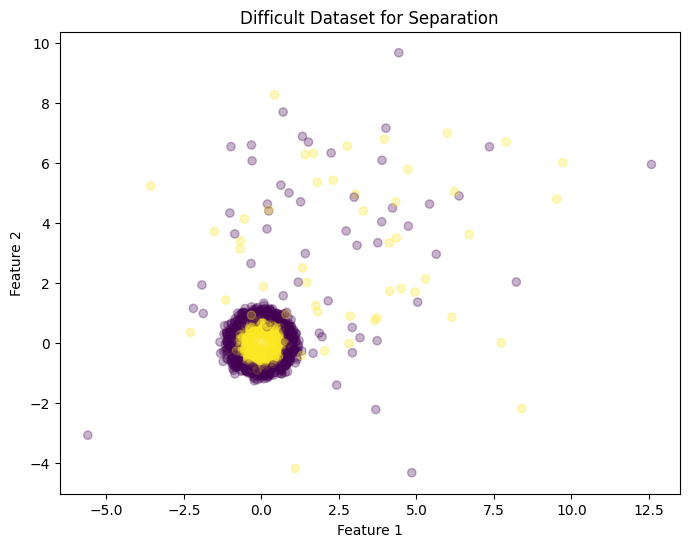

In [ ]:
# prompt: generate a difficult dataset to seperate using sklearn and plot it

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_circles, make_moons, make_blobs

# Generate a dataset with overlapping clusters
X, y = make_circles(n_samples=1000, noise=0.1, factor=0.5, random_state=42)

# Add some noise and outliers
X = X + np.random.randn(*X.shape) * 0.1
X = np.concatenate((X, np.random.randn(100, 2) * 3 + [3, 3]), axis=0)
y = np.concatenate((y, np.random.randint(0, 2, size=100)), axis=0)

X = torch.tensor(X, dtype=torch.float32)

# Plot the dataset
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', alpha=0.3)
plt.title('Difficult Dataset for Separation')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

In [ ]:
class Kerneling(nn.Module):
  def __init__(self, input_size, hidden_size, ini = True):
    super(Kerneling, self).__init__()
    self.w = torch.randn([hidden_size, input_size], dtype=torch.float32, requires_grad= True)
    if ini:
      with torch.no_grad():
        self.w = self.w / torch.sqrt(torch.tensor(2.0)/(hidden_size))
    self.b = torch.zeros([hidden_size], dtype=torch.float32, requires_grad= True)
    self.gamma = torch.ones([hidden_size], dtype=torch.float32, requires_grad= True)

  def forward(self, x):
    arr = self.w - x[:, None, :]
    return torch.exp(torch.sum((arr * arr), axis=2) * -self.gamma) + self.b

In [ ]:
class Polynomizing(nn.Module):
  def __init__(self, input_size, hidden_size):
    super(Polynomizing, self).__init__()
    self.w = nn.Linear(input_size, hidden_size, dtype=torch.float32)
    self.c = torch.zeros([hidden_size], dtype=torch.float32, requires_grad= True)
    self.b = torch.zeros([hidden_size], dtype=torch.float32, requires_grad= True)
    self.deg = nn.Parameter(torch.tensor(1.0), requires_grad= True)

  def forward(self, x):
    arr = self.w(x) + self.c
    return torch.sign(arr) * torch.abs(arr) ** self.deg  + self.b

In [ ]:
F = 2
H = 15
C = 2

In [ ]:
model = nn.Sequential(
    Kerneling(F, H, False),
    nn.BatchNorm1d(H),
    Kerneling(H, C),
    nn.BatchNorm1d(C),
    nn.Linear(C, 1)
)

In [ ]:
relu_model = nn.Sequential(
    nn.Linear(F, H),
    nn.ReLU(),
    nn.Linear(H, C),
    nn.ReLU(),
    nn.Linear(C, 1)
)

In [ ]:
poly_model = nn.Sequential(
    Polynomizing(F, H),
    nn.BatchNorm1d(H),
    Polynomizing(H, C),
    nn.BatchNorm1d(C),
    nn.Linear(C, 1)
)

In [ ]:
criterion = torch.nn.BCEWithLogitsLoss()
optim = torch.optim.Adam(model.parameters(), lr=1e-3)
relu_optim = torch.optim.Adam(relu_model.parameters(), lr=1e-3)
poly_optim = torch.optim.Adam(poly_model.parameters(), lr=1e-3)

In [ ]:
ITERS = 2500

In [ ]:
def train(model, optim):
  for i in range(ITERS):
    loss = criterion(model(X).view(-1), torch.tensor(y, dtype=torch.float32, requires_grad=True))
    optim.zero_grad()
    loss.backward()
    optim.step()
    if i % 500 == 0:
      print(loss)

In [ ]:
train(model, optim)

tensor(0.7296, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6196, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


In [ ]:
train(relu_model, relu_optim)

tensor(0.7018, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.5709, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.3489, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.2882, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.2569, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


In [ ]:
train(poly_model, poly_optim)

tensor(0.7395, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.3817, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.3045, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.2704, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.2547, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


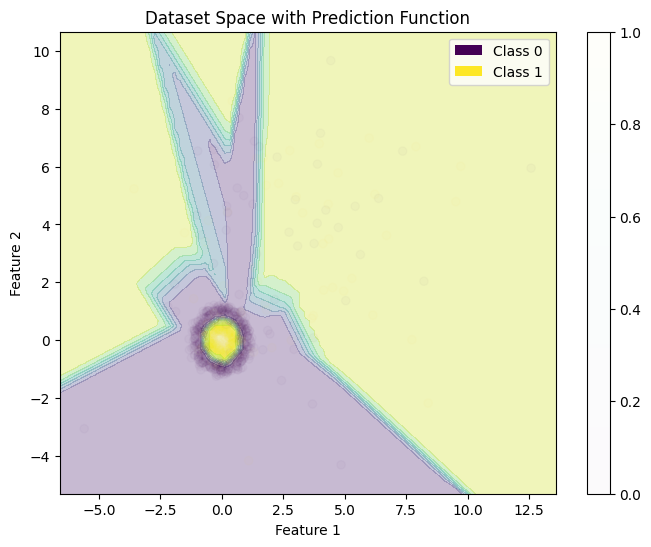

In [ ]:
# prompt: plot the dataset space and color it using the function pred(x) and add a legend for the cmap

import torch
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_circles, make_moons, make_blobs


def pred(x):
  with torch.no_grad():
    return torch.nn.Sigmoid()(relu_model(torch.tensor(x, dtype=torch.float32)))


# Create a meshgrid for plotting the decision boundary
xx, yy = np.meshgrid(np.linspace(X[:, 0].min() - 1, X[:, 0].max() + 1, 100),
                     np.linspace(X[:, 1].min() - 1, X[:, 1].max() + 1, 100))
grid = np.c_[xx.ravel(), yy.ravel()]

# Get predictions for the meshgrid
Z = pred(grid)
Z = Z.reshape(xx.shape)

# Plot the dataset and the decision boundary
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, cmap='viridis', alpha=0.3)  # Color the space based on pred(x)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', alpha=0.02)
plt.title('Dataset Space with Prediction Function')
plt.xlabel('Feature 1')
plt.colorbar()
plt.ylabel('Feature 2')

# Add a legend for the cmap
from matplotlib.patches import Patch
cmap = plt.cm.viridis
legend_elements = [Patch(facecolor=cmap(0.), label='Class 0'),
                   Patch(facecolor=cmap(1.), label='Class 1')]
plt.legend(handles=legend_elements, loc='best')

plt.show()